In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import glob
import pymesh
from sklearn import decomposition
import re

# Interpolando vertices

In [2]:
#data = pd.read_csv("../../Datos/data_artificial_cites/landmarking_600f&m.csv",sep=",",header=0,index_col=0,nrows=450)
data = pd.read_csv("../../Datos/data_artificial_cites/landmarks_reales.csv",sep=",",header=0,index_col=0)

In [3]:
data.columns

Index(['id', 'cloud_X', 'cloud_Y', 'cloud_Z', 'S000_X', 'S001_X', 'S002_X',
       'S003_X', 'S004_X', 'S005_X', 'S006_X', 'S007_X', 'S008_X', 'S009_X',
       'S010_X', 'S011_X', 'S012_X', 'S013_X', 'S014_X', 'S000_Y', 'S001_Y',
       'S002_Y', 'S003_Y', 'S004_Y', 'S005_Y', 'S006_Y', 'S007_Y', 'S008_Y',
       'S009_Y', 'S010_Y', 'S011_Y', 'S012_Y', 'S013_Y', 'S014_Y', 'S000_Z',
       'S001_Z', 'S002_Z', 'S003_Z', 'S004_Z', 'S005_Z', 'S006_Z', 'S007_Z',
       'S008_Z', 'S009_Z', 'S010_Z', 'S011_Z', 'S012_Z', 'S013_Z', 'S014_Z'],
      dtype='object')

In [4]:
ids = np.array(data['id'])
cloud_Xs = np.array(data['cloud_X'])
cloud_Ys = np.array(data['cloud_Y'])
cloud_Zs = np.array(data['cloud_Z'])

In [5]:
def from_string(a):
    return np.fromstring(a,sep=" ")

In [6]:
Xs = np.array(list(map(lambda x: from_string(x),cloud_Xs)))
Ys = np.array(list(map(lambda x: from_string(x),cloud_Ys)))
Zs = np.array(list(map(lambda x: from_string(x),cloud_Zs)))

In [7]:
shapes_Xs = np.array(list(map(lambda x: np.shape(x),Xs)))

In [8]:
max_shape = shapes_Xs.flatten().max()

In [9]:
max_shape

100187

In [10]:
def completar(a):
    zeros = np.zeros(204900)
    zeros[0:a.shape[0]] = a
    return zeros

In [11]:
Xs = np.array(list(map(lambda x: completar(x),Xs)))
Ys = np.array(list(map(lambda x: completar(x),Ys)))
Zs = np.array(list(map(lambda x: completar(x),Zs)))

In [12]:
values = np.column_stack((Xs,Ys,Zs))

In [13]:
#values_1 = values

In [14]:
del data,Xs,Ys,Zs

In [15]:
del cloud_Xs,cloud_Ys,cloud_Zs

In [16]:
del shapes_Xs

In [17]:
ids_int = np.array(list(map(lambda x: re.findall(r'\d+', x),ids)),dtype=int).flatten()

In [18]:
filtro = ids_int != 25

In [19]:
values = values[filtro]

In [20]:
ids_int = ids_int[filtro]

# Reducción de dimensionalidad PCA 

In [64]:
pca = decomposition.PCA(n_components=50,svd_solver='full',whiten=False)
pca.fit(values)
print("Con n_components = {} el valor es: {} ".format(50,pca.explained_variance_ratio_.sum()))

Con n_components = 50 el valor es: 0.8246447153565328 


In [65]:
x_out = pca.transform(values)
x_out.shape

(148, 50)

In [66]:
data_reales = pd.read_excel("../../Datos/CampañaVoluntario/23-05-2017-completo.xlsx")

In [67]:
sexo_ids = np.array(data_reales["sexo"])

In [68]:
sexo_ids = sexo_ids[filtro]

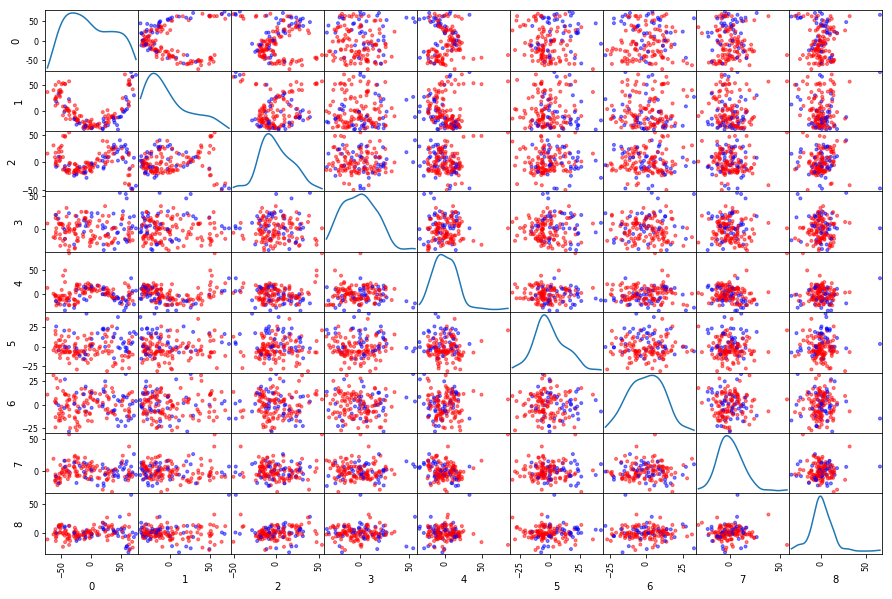

In [69]:
interest_feat = range(10)
data = pd.DataFrame(x_out)
data["labels"]= sexo_ids
color_wheel = {"f": "red", "m": "blue"}
colors = data["labels"].map(lambda x: color_wheel.get(x[0]))
pd.scatter_matrix(data.loc[:,interest_feat[:-1]], figsize=(15,10), diagonal='kde',label=data.loc[:,"labels"],c=colors)
plt.show()

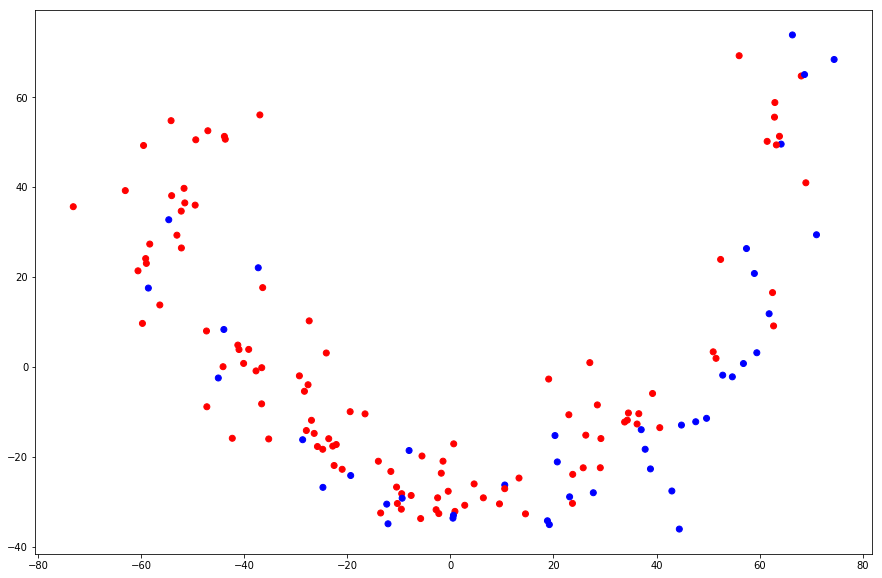

In [70]:
import matplotlib.patches as mpatches
plt.rcParams["figure.figsize"] = [15,10]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_out[:,0],x_out[:,1],marker="o",c=colors)
# for label, x, y in zip(np.array(ids_int), x_out[:,0], x_out[:,1]):
#     plt.annotate(
#         label,
#         xy=(x, y), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.show()

# Prediciendo

In [71]:
import sklearn
from sklearn.svm import SVC

In [72]:
id_sexo = {"f": 0, "m": 1}
sexo_c = data["labels"].map(lambda x: id_sexo.get(x[0])).tolist()

In [73]:
#X = x_out[:,[0,5]]
X = x_out
y = sexo_c

In [74]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split( X, y, test_size=0.30, random_state=42)

In [75]:
clf = SVC()
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [76]:
clf.score(X_test,y_test)

0.62222222222222223

In [77]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
clf = ExtraTreesClassifier(n_estimators=200,
                           max_features=0.3,
                           #max_depth=4, #20
                           random_state=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.63      0.93      0.75        28
          1       0.50      0.12      0.19        17

avg / total       0.58      0.62      0.54        45



In [59]:
clf.score(X_test,y_test)

0.62222222222222223

In [60]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)

In [61]:
scores.mean()

0.70195031516499806

In [62]:
scores.std()

0.058249166679069514

In [63]:
scores 

array([ 0.74193548,  0.73333333,  0.5862069 ,  0.72413793,  0.72413793])

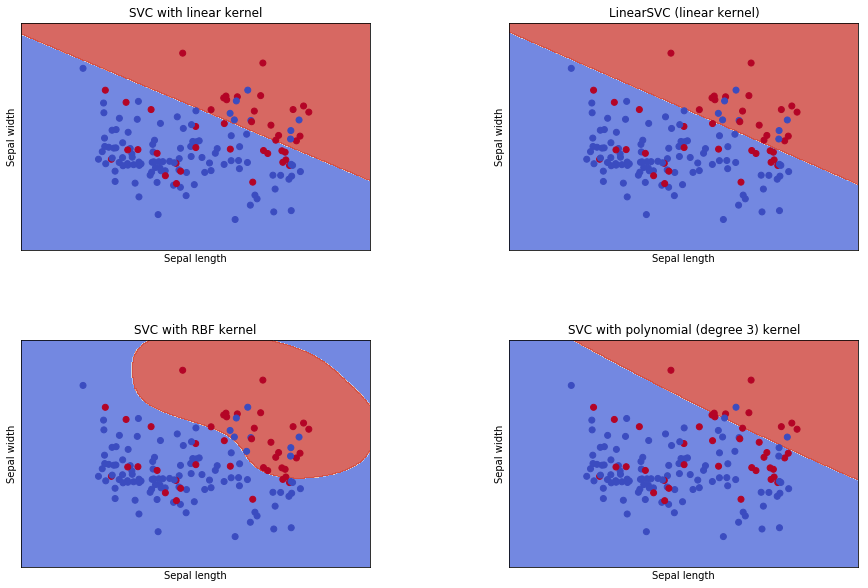

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data[:, :2]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()